In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer

In [3]:
#sklearn will return a pandas dataframe insted of a numpy array
random_state = 42
sns.set_style("darkgrid")

# Load Data

In [4]:
nba       = pd.read_csv('../data/nba/nba_salaries.csv')
insurance = pd.read_csv('../data/insurance/insurance.csv')
airline   = pd.read_csv('../data/airline/train.csv')
airbnb    = pd.read_csv('../data/airbnb/listings.csv')

# Skewness

## Initial Version

In [5]:
def correct_skew(df: pd.DataFrame, 
                 feature: str, 
                 max_power: int = 50,
                 initial_skew_threshold: float = 0.5,
                 final_skew_threshold: float = 0.1,
                 plot: bool = False,
                 verbose = True) :
    
    """
    Correct skewness of a feature using different transformations

    """

    df = df.copy()

    #remove nan
    initial_number_rows = len(df)
    df = df.dropna(subset=[feature])
    not_na_rows = len(df)
    if verbose:
        print(f'Number of rows removed due to NAN : {initial_number_rows - not_na_rows}')

    df_temp = df.copy()

    #subsample
    if df_temp.memory_usage().sum() > 1000000:
        df_temp = df.sample(frac=round(5000 / df.shape[0], 2))
    subsampled_number_rows = len(df_temp)
    if subsampled_number_rows == not_na_rows:
        if verbose:
            print('It was not necessary to subsample the dataframe')
        subsampled = False #variable to indicate whether the dataframe was subsampled
    else:
        if verbose:
            print(f'{not_na_rows - subsampled_number_rows} rows from {not_na_rows} were removed due to subsampling')
        subsampled = True #variable to indicate whether the dataframe was subsampled
    #if the dataframe was subsampled, then the subsampled dataframe will be stored in df_temp. Otherwise, df_temp will be equal to df
    #the subsampled dataframe will be used to plot the histograms, and the original dataframe will be used to store the transformed features

    skew = df[feature].skew()
    text_initial_skew = f'Initial Skewness: {round(skew, 4)}'

    #the dictionary will be used to store the results of the different transformations
    results = {}

    #Positively skewed feature
    if skew > initial_skew_threshold:
        #positively skewed features will be raised to 1/power
        power = 1
        power_step = 0.01
        #search for the power that makes the skewness close to 0
        while round(skew, 2) != 0 and power <= max_power:
            power += power_step
            skew = np.power(df[feature], 1/power).skew()
        rounded_power = round(power, 3)

        feature_power_name = f'{feature}_raised_to_(1/{rounded_power})' #name of the transformed feature
        df_temp[feature_power_name] = np.power(df_temp[feature], 1/power)   
        text_power_skew = f'Skewness after raising to 1/{rounded_power}: {round(skew, 4)}' #title of the plot
        results[feature_power_name] = abs(round(skew, 4)) 

        #log transformation
        feature_log_name = f'{feature}_log_transformed' #name of the transformed feature
        df_temp[feature_log_name] = np.log(df_temp[feature] + 1e-7)
        skew = df_temp[feature_log_name].skew()
        text_log_skew = f'Skewness after log transformation: {round(skew, 4)}' #title of the plot
        results[feature_log_name] = abs(round(skew, 4))

        #Yeo Jhonson transformation
        feature_yeo_name = f'{feature}_yeo_johnson_transformed' #name of the transformed feature
        pwr_transformer = PowerTransformer(method='yeo-johnson')
        df_temp[feature_yeo_name] = pwr_transformer.fit_transform(df_temp[feature].values.reshape(-1, 1))
        skew = df_temp[feature_yeo_name].skew()
        text_yeo_skew = f'Skewness after Yeo Jhonson transformation: {round(skew, 4)}' #title of the plot
        results[feature_yeo_name] = abs(round(skew, 4))

        #Creating plots
        if plot:
            fig, axs = plt.subplots(3, 2, figsize=(15, 12))
            sns.histplot(df_temp[feature], ax=axs[0,0], kde=True, stat='density')
            sns.histplot(df_temp[feature_power_name], ax=axs[0,1], kde=True, stat='density')
            sns.histplot(df_temp[feature_log_name], ax=axs[1,0], kde=True, stat='density')
            sns.histplot(df_temp[feature_yeo_name], ax=axs[1,1], kde=True, stat='density')
            axs[0, 0].set_title(text_initial_skew)
            axs[0,1].set_title(text_power_skew)
            axs[1,0].set_title(text_log_skew)
            axs[1,1].set_title(text_yeo_skew)

        #test whether the transformation were successful
        #if the skewness is larger than skew_threshold, then the transformation was not successful
        #and the skewed feature will be converted in a binary feature
        if min(results.values()) > final_skew_threshold:
            if verbose:
                print(f'It was not possible to make the {feature} distribution close to normal, therefore if will be converted into a binary feature')
            binary_feature_name = f'{feature}_binary'
            df_temp[binary_feature_name] = np.where(df_temp[feature] == df_temp[feature].min(), 0, 1)
            if subsampled:
                #create the new binary feature in the original dataframe
                df[binary_feature_name] = np.where(df[feature] == df[feature].min(), 0, 1)                
            text_binary_feature = f'{feature} was converted in a binary feature' #title of the plot
            sns.countplot(data = df_temp, x = binary_feature_name, ax=axs[2,0])
            axs[2,0].set_title(text_binary_feature)
            fig.delaxes(axs[2, 1])
            plt.tight_layout()
            plt.show()
        else:
            #delete the unnecessary axis
            fig.delaxes(axs[2, 0])
            fig.delaxes(axs[2, 1])
            plt.tight_layout()
            plt.show()
            
            #min_key is the transformation that produced the best results
            min_key = min(results, key=results.get)

            #create the new transformed feature in the original dataframe
            #only the transformed feature that produced the best result will be created
            if subsampled:
                if min_key == feature_power_name:
                    df[feature_power_name] = np.power(df[feature], 1/power)
                elif min_key == feature_log_name:
                    df[feature_log_name] = np.log(df[feature] + 1e-7)
                elif min_key == feature_yeo_name:
                    df[feature_yeo_name] = pwr_transformer.fit_transform(df[feature].values.reshape(-1, 1))
            #if sumsampled is false, then only the transformed feature that produced the best result will be kept in df_temp
            else:
                for feature_name in [feature_power_name, feature_log_name, feature_yeo_name]:
                    if feature_name != min_key:
                        df_temp = df_temp.drop(columns=[feature_name])

            
    # Negatively skewed feature
    elif skew < - initial_skew_threshold:
        # raise feature to power 2
        feature_power2_name = f'{feature}_raised_to_2' #name of the transformed feature
        df_temp[feature_power2_name] = np.power(df_temp[feature], 2) 
        skew = df_temp[feature_power2_name].skew()
        results[feature_power2_name] = abs(round(skew, 4))
        text_power_2 = f'Skewness after squared transformation: {round(skew, 4)}' #title of the plot

        # raise feature to power 3
        feature_power3_name = f'{feature}_raised_to_3' #name of the transformed feature
        df_temp[feature_power3_name] = np.power(df_temp[feature], 3) 
        skew = df_temp[feature_power3_name].skew()
        results[feature_power3_name] = abs(round(skew, 4)) 
        text_power_3 = f'Skewness after cubic transformation: {round(skew, 4)}' #title of the plot

        #log transformation
        feature_log_name = f'{feature}_log_transformed' #name of the transformed feature
        df_temp[feature_log_name] = df_temp[feature] + 1 - df_temp[feature].max()
        df_temp[feature_log_name] = np.log(df_temp[feature_log_name])
        skew = df_temp[feature_log_name].skew()
        results[feature_log_name] = abs(round(skew, 4))
        text_log_skew = f'Skewness after log transformation: {round(skew, 4)}' #title of the plot

        #Yeo Jhonson transformation
        feature_yeo_name = f'{feature}_yeo_johnson_transformed' #name of the feature
        pwr_transformer = PowerTransformer(method='yeo-johnson')
        df_temp[feature_yeo_name] = pwr_transformer.fit_transform(df_temp[feature].values.reshape(-1, 1))
        skew = df_temp[feature_yeo_name].skew()
        results['yeo'] = abs(round(skew, 4))
        text_yeo_skew = f'Skewness after Yeo Jhonson transformation: {round(skew, 4)}' #title of the plot

        #creating plots
        fig, axs = plt.subplots(3, 2, figsize=(15, 12))
        sns.histplot(df[feature], ax=axs[0,0], kde=True, stat='density')
        sns.histplot(df_temp[feature_power2_name], ax=axs[0,1], kde=True, stat='density')
        sns.histplot(df_temp[feature_power3_name], ax=axs[1,0], kde=True, stat='density')
        sns.histplot(df_temp[feature_log_name], ax=axs[1,1], kde=True, stat='density')
        sns.histplot(df_temp[feature_yeo_name], ax=axs[2,1], kde=True, stat='density')

        axs[0, 0].set_title(text_initial_skew)
        axs[0,1].set_title(text_power_2)
        axs[1,0].set_title(text_power_3)
        axs[1,1].set_title(text_log_skew)
        axs[2,1].set_title(text_yeo_skew)

        #test whether the transformation were successful
        #if the skewness is larger than skew_threshold, then the transformation was not successful
        #and the skewed feature will be converted in a binary feature
        if min(results.values()) > final_skew_threshold:
            print(f'It was not possible to make the {feature} distribution close to normal, therefore if will be converted into a binary feature')
            binary_feature_name = f'{feature}_binary' #name of the binary feature
            df_temp[binary_feature_name] = np.where(df_temp[feature] == df_temp[feature].max(), 1, 0)
            if subsampled:
                #create the new binary feature in the original dataframe
                df[binary_feature_name] = np.where(df[feature] == df[feature].max(), 1, 0)
            text_binary_feature = f'{feature} was converted in a binary feature' #name of the plot
            sns.countplot(data = df_temp, x = binary_feature_name, ax=axs[2,20])
            axs[2,2].set_title(text_binary_feature)
            plt.tight_layout()
            plt.show()  
        else:
            fig.delaxes(axs[2, 2])
            plt.tight_layout()
            plt.show()
            min_key = min(results, key=results.get)

            #create the new transformed feature in the original dataframe
            #only the transformed feature that produced the best result will be created
            if subsampled:
                if min_key == feature_power2_name:
                    df[feature_power2_name] = np.power(df[feature], 2)
                elif min_key == feature_power3_name:
                    df[feature_power3_name] = np.power(df[feature], 3)
                elif min_key == feature_log_name:
                    df[feature_log_name] = df[feature] - df[feature].max() + 1
                elif min_key == feature_yeo_name:
                    df[feature_yeo_name] = pwr_transformer.fit_transform(df[feature].values.reshape(-1, 1))
            #if sumsampled is false, then only the transformed feature that produced the best result will be kept in df_temp
            else:
                for feature_name in [feature_power2_name, feature_power3_name, feature_log_name, feature_yeo_name]:
                    if feature_name != min_key:
                        df_temp = df_temp.drop(columns=[feature_name])  

    
    
    return df_temp, results


## Refactored Version

In [ ]:
def remove_nans_and_subsample(df: pd.DataFrame, 
                             feature: str, 
                             verbose: bool = True, 
                             subsample_limit: int = 5000):
    """
    Removes NaNs from the specified feature and optionally subsamples the DataFrame
    if it has more rows than `subsample_limit`.

    Returns:
        - df_cleaned: DataFrame without NaNs in the feature
        - df_sampled: Possibly subsampled version of df_cleaned (or same as df_cleaned)
        - was_subsampled: Boolean flag
    """
    df = df.copy()
    initial_len = len(df)
    df = df.dropna(subset=[feature])
    
    if verbose:
        print(f"Removed {initial_len - len(df)} rows with NaN in '{feature}'")

    if len(df) > subsample_limit:
        df_sampled = df.sample(n=subsample_limit, random_state=42)
        if verbose:
            print(f"Subsampled to {len(df_sampled)} rows from {len(df)}")
        return df, df_sampled, True

    if verbose:
        print("No subsampling applied")
    return df, df, False

def plot_transformations(titles_series_dict: dict[str, pd.Series], 
                         original_series: pd.Series, 
                         original_title: str) -> None:
    """
    Plot original and transformed feature distributions.

    Parameters:
        titles_series_dict (dict): Dictionary mapping titles to transformed Series.
        original_series (pd.Series): Original feature data.
        original_title (str): Title for the original distribution plot.
    """
    n = len(titles_series_dict) + 1
    rows = (n + 1) // 2
    fig, axs = plt.subplots(rows, 2, figsize=(15, 4 * rows))
    axs = axs.flatten()

    sns.histplot(original_series, ax=axs[0], kde=True, stat='density')
    axs[0].set_title(original_title)

    for i, (title, series) in enumerate(titles_series_dict.items(), start=1):
        sns.histplot(series, ax=axs[i], kde=True, stat='density')
        axs[i].set_title(title)

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

def apply_transformations(
    df_temp: pd.DataFrame, 
    feature: str, 
    initial_skew: float,
    max_power: int,
    plot: bool = False,  
    skew_threshold: float = 0.5,
    num_power_iterations: int = 100
) -> tuple[dict[str, pd.Series], dict[str, float]]:
    """
    Apply transformations to reduce skewness in a DataFrame column.

    Parameters:
        df_temp (pd.DataFrame): DataFrame containing the feature to transform.
        feature (str): Column name of the feature.
        initial_skew (float): Initial skewness value.
        max_power (int): Upper limit for inverse power transformation.
        plot (bool): Whether to generate histograms of transformations.
        skew_threshold (float): Threshold above which skew is considered significant.
        num_power_iterations (int): Number of inverse power tests to try.

    Returns:
        transformed (dict): Transformed feature series.
        results (dict): Absolute skewness values of the transformations.
    """
    results = {}
    transformed = {}

    epsilon = 1e-7  # Prevent log(0)
    initial_skew_plot_title = f'Initial Skewness: {round(initial_skew, 4)}'

    if initial_skew > skew_threshold:
        skew_power_transformation = {}
        powers = np.linspace(1.01, max_power, num_power_iterations)

        for power in powers:
            skew = np.power(df_temp[feature], 1/power).skew()
            skew_power_transformation[power] = skew

        power_min_skew = min(skew_power_transformation, key=lambda k: abs(skew_power_transformation[k]))
        best_skew = skew_power_transformation[power_min_skew]

        feature_power_name = f"{round(1/power_min_skew, 3)}"
        transformed[feature_power_name] = np.power(df_temp[feature], 1/power_min_skew)
        results[feature_power_name] = abs(round(best_skew, 4))
        skewness_power_plot_title = f'Skewness after raising to 1/{round(power_min_skew, 3)}: {round(best_skew, 4)}'

        feature_log_name = 'log'
        transformed[feature_log_name] = np.log(df_temp[feature] + epsilon)
        log_skew = transformed[feature_log_name].skew()
        results[feature_log_name] = abs(log_skew)
        skewness_log_plot_title = f'Skewness after log transformation: {round(log_skew, 4)}'

        feature_yeo_name = 'yeo'
        pwr = PowerTransformer(method='yeo-johnson')
        transformed[feature_yeo_name] = pwr.fit_transform(df_temp[[feature]]).flatten()
        yeo_skew = pd.Series(transformed[feature_yeo_name]).skew()
        results[feature_yeo_name] = abs(yeo_skew)
        skewness_yeo_plot_title = f'Skewness after Yeo-Johnson transformation: {round(yeo_skew, 4)}'

        if plot:
            plot_transformations(
                {
                    skewness_power_plot_title: transformed[feature_power_name],
                    skewness_log_plot_title: transformed[feature_log_name],
                    skewness_yeo_plot_title: transformed[feature_yeo_name],
                },
                df_temp[feature],
                initial_skew_plot_title
            )

    elif initial_skew < -skew_threshold:
        feature_power2_name = str(2)
        transformed[feature_power2_name] = np.power(df_temp[feature], 2)
        skew2 = transformed[feature_power2_name].skew()
        results[feature_power2_name] = abs(skew2)
        skewness_power2_plot_title = f'Skewness after raising to 2: {round(skew2, 4)}'

        feature_power3_name = str(3)
        transformed[feature_power3_name] = np.power(df_temp[feature], 3)
        skew3 = transformed[feature_power3_name].skew()
        results[feature_power3_name] = abs(skew3)
        skewness_power3_plot_title = f'Skewness after raising to 3: {round(skew3, 4)}'

        feature_log_name = 'log'
        shifted = df_temp[feature] + 1 - df_temp[feature].max()
        transformed[feature_log_name] = np.log(shifted)
        log_skew = transformed[feature_log_name].skew()
        results[feature_log_name] = abs(log_skew)
        skewness_log_plot_title = f'Skewness after log transformation: {round(log_skew, 4)}'

        feature_yeo_name = 'yeo'
        pwr = PowerTransformer(method='yeo-johnson')
        transformed[feature_yeo_name] = pwr.fit_transform(df_temp[[feature]]).flatten()
        yeo_skew = pd.Series(transformed[feature_yeo_name]).skew()
        results[feature_yeo_name] = abs(yeo_skew)
        skewness_yeo_plot_title = f'Skewness after Yeo-Johnson transformation: {round(yeo_skew, 4)}'

        if plot:
            plot_transformations(
                {
                    skewness_power2_plot_title: transformed[feature_power2_name],
                    skewness_power3_plot_title: transformed[feature_power3_name],
                    skewness_log_plot_title: transformed[feature_log_name],
                    skewness_yeo_plot_title: transformed[feature_yeo_name],
                },
                df_temp[feature],
                initial_skew_plot_title
            )

    else:
        return {}, {}

    return transformed, results

def select_best_transformation(results: dict, 
                    final_threshold: float) -> tuple[str, bool]:
    """
    Select the transformation that produced the minimum skewness

    Parameters:
        results (dict): A dictionary containing the skewness values for different transformations.
        final_threshold (float): The threshold for considering a transformation successful.

    Returns:
        tuple: A tuple containing the best transformation and a boolean indicating success.
    """
    best_transformation = min(results, key=results.get)
    best_skew = results[best_transformation]
    success = best_skew <= final_threshold
    return best_transformation, success

def apply_final_transformation(df: pd.DataFrame, 
                               transformed: dict, 
                               best_tranformation: str, 
                               feature: str, 
                               subsampled: bool,
                               skew_positive: bool):
    """
    Apply the best transformation to correct the skewness.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the feature to transform.
        transformed (dict): A dictionary containing the transformed feature series.
        best_tranformation (str): The best transformation to apply.
        feature (str): The name of the feature to transform.
        subsampled (bool): A boolean indicating whether the feature is subsampled.  
        skew_positive (bool): A boolean indicating whether the feature is positively skewed.

    Returns:
        pd.DataFrame: The DataFrame with the transformed feature added.   
    """


    epsilon = 1e-7

    #If subsampled is false, the transformed dictionary contains the transformed series for each transformation 
    #applied to the entire dataset. Otherwise, the transformations were applied to the subsampled dataset

    if subsampled:

        if best_tranformation == 'log':
            if skew_positive:
                df[feature + '_transformed'] = np.log(df[feature] + epsilon)
            else:
                shifted = df[feature] + 1 - df[feature].max()
                df[feature + '_transformed'] = np.log(shifted + epsilon)
        
        elif best_tranformation == 'yeo':
            pwr = PowerTransformer(method='yeo-johnson')
            df[feature + '_transformed'] = pwr.fit_transform(df[[feature]]).flatten()
    
        else:
            power = round(float(best_tranformation), 3)
            df[feature + '_transformed'] = np.power(df[feature], power)
    #subsampled is false, the transformation were already applied to the entire dataset
    else:
        df[feature + '_transformed'] = transformed[best_tranformation]

    return df

def fallback_to_binary(df, 
                       feature, 
                       skew_positive=True
                       ):
    """
    Convert the feature to binary if it is positively skewed or negatively skewed

    Parameters:
        df (pd.DataFrame): The DataFrame containing the feature to transform.
        feature (str): The name of the feature to transform.
        skew_positive (bool): A boolean indicating whether the feature is positively skewed.

    Returns:
        pd.DataFrame: The DataFrame with the transformed feature added.
    """

    
    binary_feature = f"{feature}_binary"
    if skew_positive:
        df[binary_feature] = (df[feature] != df[feature].min()).astype(int)
       
    else:
        df[binary_feature] = (df[feature] == df[feature].max()).astype(int)
        
    return df 

def correct_skew(df, feature, max_power=50, 
                 initial_skew_threshold=0.5, 
                 final_skew_threshold=0.1, 
                 plot_all_transformations=False, 
                 plot_transformed_feature=False,
                 verbose=True):
    """
    Automatically detects skewness in a DataFrame feature, applies the best transformation 
    to reduce skewness, or converts it to binary if transformation fails.

    Parameters: 
        df (pd.DataFrame): The DataFrame containing the feature to transform.
        feature (str): The name of the feature to transform.
        max_power (int): The maximum power to apply to the feature (only valid for positively skewed features).
        initial_skew_threshold (float): The threshold for applying transformations.
        final_skew_threshold (float): The threshold for considering a transformation successful.
        plot_all_transformations (bool): A boolean indicating whether to plot the results for all transformations.
        plot_transformed_feature (bool): A boolean indicating whether to plot the transformed feature.
        verbose (bool): A boolean indicating whether to print verbose output.

    Returns:
        pd.DataFrame: The DataFrame with the transformed feature added. 
    """
    df, df_temp, subsampled = remove_nans_and_subsample(df, feature, verbose)
    skew = df[feature].skew()
    if verbose:
        print(f"Initial Skewness: {round(skew, 4)}")

    if skew < initial_skew_threshold:
        if verbose:
            print("Feature not sufficiently skewed. No transformation applied.")
            return df_temp

    transformed, results = apply_transformations(df_temp, 
                                                 feature, 
                                                 initial_skew = skew, 
                                                 max_power = max_power,
                                                 plot = plot_all_transformations,
                                                 skew_threshold = initial_skew_threshold,
                                                 num_power_iterations = 100)

    best_transformation, success = select_best_transformation(results, final_skew_threshold)

    if not success:
        if verbose:
            print(f"Could not reduce skewness below threshold. Converting '{feature}' to binary.")
        df_out = fallback_to_binary(df, feature, skew_positive=(skew > 0))
    else:
        df_out = apply_final_transformation(df, transformed, best_transformation, feature, subsampled, skew_positive=(skew > 0))

    if plot_transformed_feature:
        fig, axs = plt.subplots(1,2, figsize=(15, 6))
        sns.histplot(df_out[feature], kde=True, stat="density", ax=axs[0])
        axs[0].set_title(feature)
        if success:
            sns.histplot(df_out[feature + '_transformed'], kde=True, stat="density", ax=axs[1])
            axs[1].set_title(feature +  '_transformed')
        else:
            sns.countplot(data = df_out, x = feature + '_binary', ax=axs[1])
            axs[1].set_title(feature +  '_binary')


    return df_out, results




<Axes: xlabel='charges', ylabel='Density'>

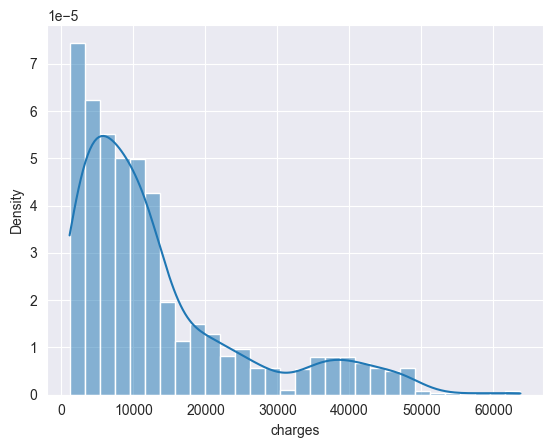

In [13]:
sns.histplot(insurance['charges'], kde=True, stat="density")

Removed 0 rows with NaN in 'charges'
No subsampling applied
Initial Skewness: 1.5159
<class 'numpy.ndarray'>


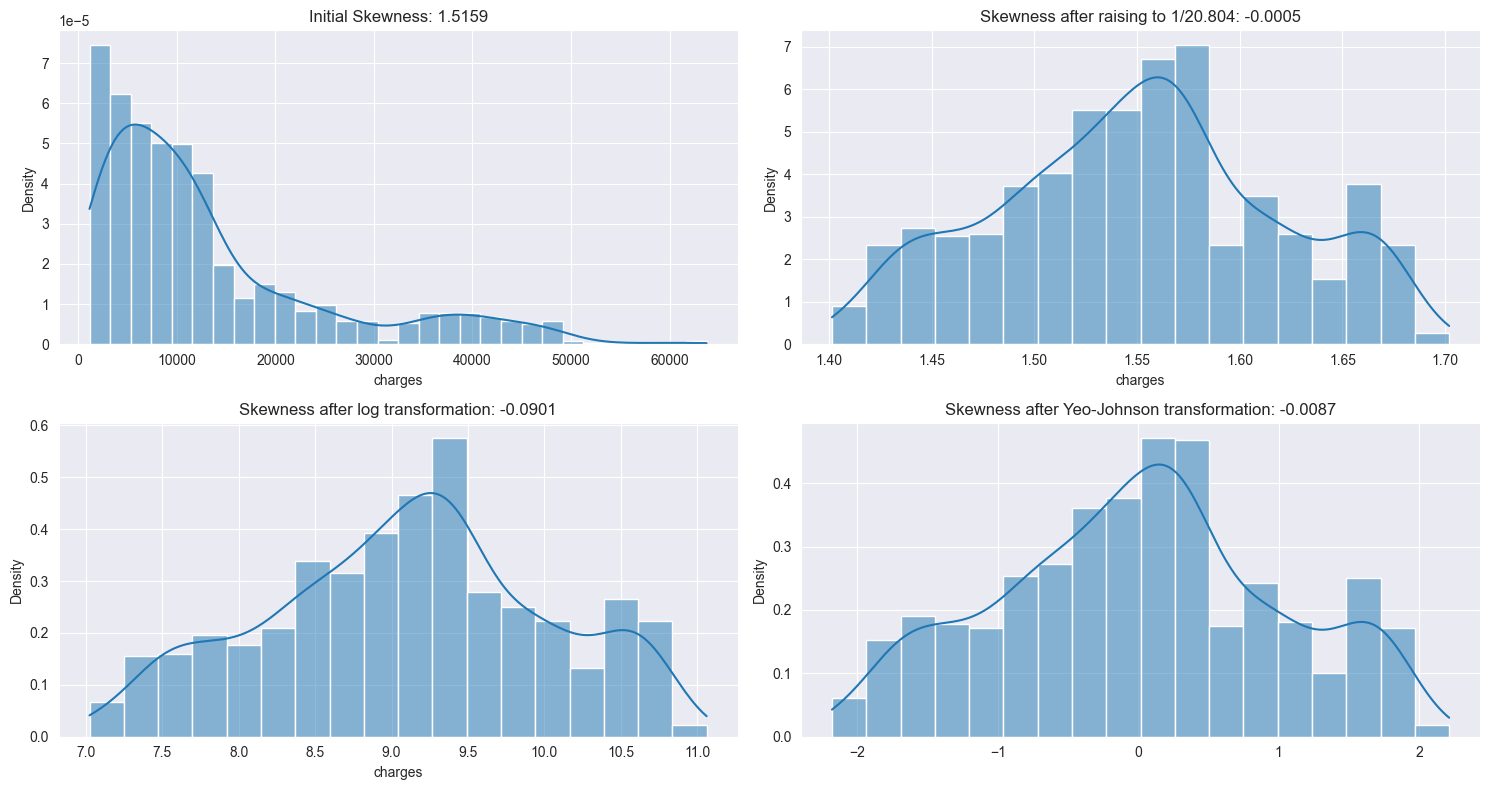

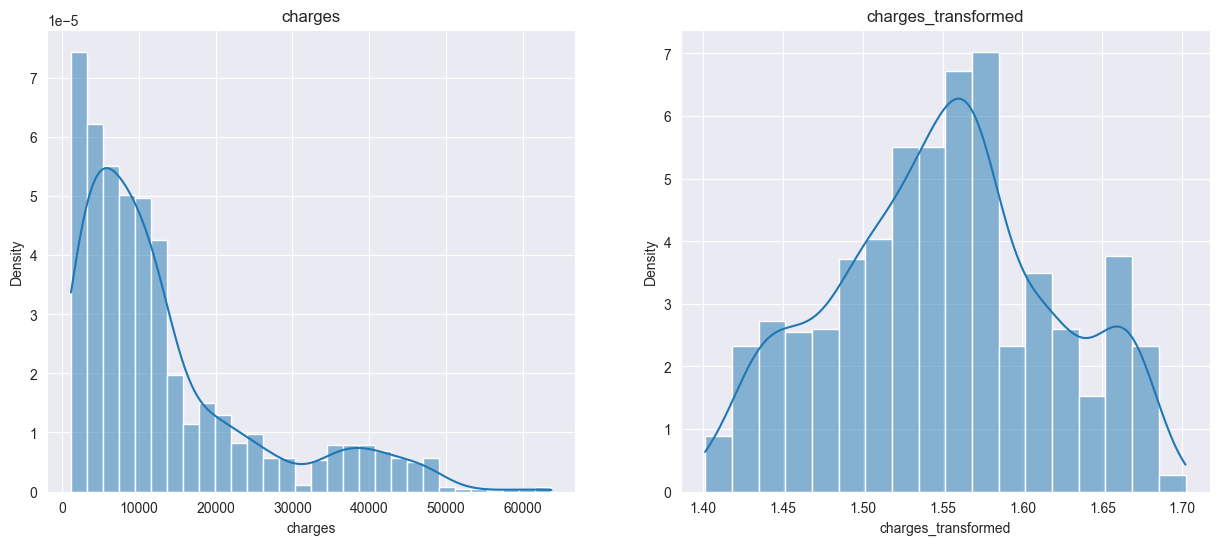

In [14]:


_, _ = correct_skew(insurance, 'charges', max_power=50, 
                 initial_skew_threshold=0.5, 
                 final_skew_threshold=0.1, 
                 plot_all_transformations=True, 
                 plot_transformed_feature=True,
                 verbose=True)